In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from sklearn.neighbors import KNeighborsRegressor
from mude_tools import magicplotter
%matplotlib nbagg

## Introduction
In the previous notebook we built a k-nearest neighbours model, and observed the influence of choosing various values for k. We found that choosing k depends, among other things, on the specific dataset used & the noise in this data. By tweaking k we could get a model which __qualitatively__ fit our data well.

In this notebook we will try to __quantify__ how wel a specific model performs for any dataset, this can help us choose the best one. We will start by repeating the code introduced in the previous notebook.

In [2]:
# The true function relating t to x
def f(x, f=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * f)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Define a function that makes a KNN prediction at the given locations, based on the given (x,t) data
def KNN(x, t, x_pred, k=1, **kwargs):
    
    # Convert x and x_pred to a column vector in order for KNeighborsRegresser to work
    X = x.reshape(-1,1)
    X_pred = x_pred.reshape(-1,1)
    
    # Train the KNN based on the given (x,t) data
    neigh = KNeighborsRegressor(k)
    neigh.fit(X, t)
    
    # Make a prediction at the locations given by x_pred
    y = neigh.predict(X_pred)
    
    # Return the predicted values
    return y

## Loss function
To quantify the "closeness" between predictions of some model $y(\mathbf{x})$ and the data $t$ we are modelling, we introduce the squared loss function:

$$ L ( t, y(\mathbf{x}))= (y(\mathbf{x}) - t)^2 $$
where $t$ are the observed values corresponding to $\mathbf{x}$. Squaring the difference gives a couple of nice properties:
* The loss is always positive, regardless of whether we underestimate or overestimate a prediction.
* Outliers have a bigger influence on the loss
* It is a convex function
* It is differentiable for $y(\mathbf{x})$=t, which is not true when considering absolute loss

Below we plot this loss for a number of datapoints. Notice that the function used is the ground truth from which the data is drawn. The error thus comes from the noise in our observations.

<IPython.core.display.Javascript object>


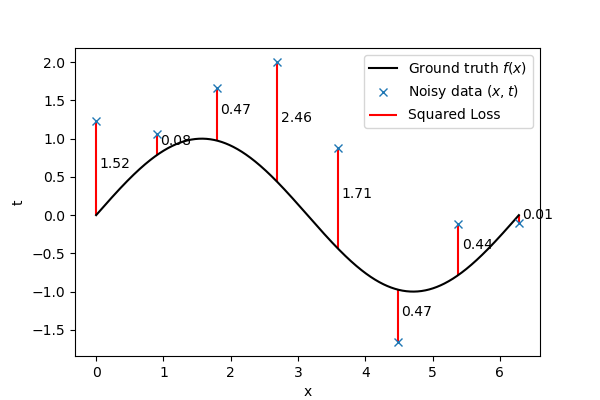

In [3]:
# Get the observed data in 8 locations
x, t = f_data(N=8, seed=0)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))
plt.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')

# Plot the difference and print the squared loss
for i, x_i in enumerate(x):
    ymin = min(t[i], f(x_i))
    ymax = max(t[i], f(x_i))
    if i == 0:    # Only plot the label once
        plt.vlines(x_i, ymin, ymax, 'r', label='Squared Loss')
    else:
        plt.vlines(x_i, ymin, ymax, 'r')
    plt.text(x_i+0.05, (ymin+ymax)/2, f'{(ymax-ymin)**2:.2f}')

plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

* If we create a model that minimizes the loss function for these points, would that model give accurate predictions for unseen data?

## Theory
To quantify our model, we want a single value that tells us how well it explains all the data. Therefore it is natural to compute the expected loss:
$$ \mathbb{E}[L]= \int \int (y(\mathbf{x})-t)^2 p( \mathbf{x},t) d\mathbf{x} dt $$
where $(y(\mathbf{x})-t)^2$ is the error term we have seen before, and we multiply it with $p( \mathbf{x},t)$, the probability of this particular point occuring.

Our goal is to choose a model $y(\mathbf{x})$ so as to minimize $\mathbb{E}[L]$. We can do this using the calculus of variations:

$$ \frac{\delta \mathbb{E}[L]}{\delta y(\mathbf{x})}= 2 \int (y(\mathbf{x})-t) p( \mathbf{x},t) dt = 0 $$
Solving for $y(\mathbf{x})$:
$$  y(\mathbf{x}) = \frac{\int t p( \mathbf{x},t) dt}{p(\mathbf{x})} = \int t p(t|\mathbf{x})dt = \mathbb{E}_t[t|\mathbf{x}]   $$
This is the conditional average of t conditioned on $\mathbf{x}$.


In practice we generally don't know $p( \mathbf{x},t)$ or $p(t|\mathbf{x})$ exactly. Instead for any model we can estimate the loss by taking the average of the squared losses for each point in our limited dataset. We can then tweak $y(\mathbf{x})$ to minimize this loss.

$$ \int \int (y(\mathbf{x})-t)^2 p( \mathbf{x},t) d\mathbf{x} dt \approx \dfrac{1}{N} \sum_i^N (y(\mathbf{x}_i)-t_i)^2 $$

This is known as the Mean Squared Error (MSE) function.

We revisit our k-nearest neighbours model, now with the loss function included.



<IPython.core.display.Javascript object>


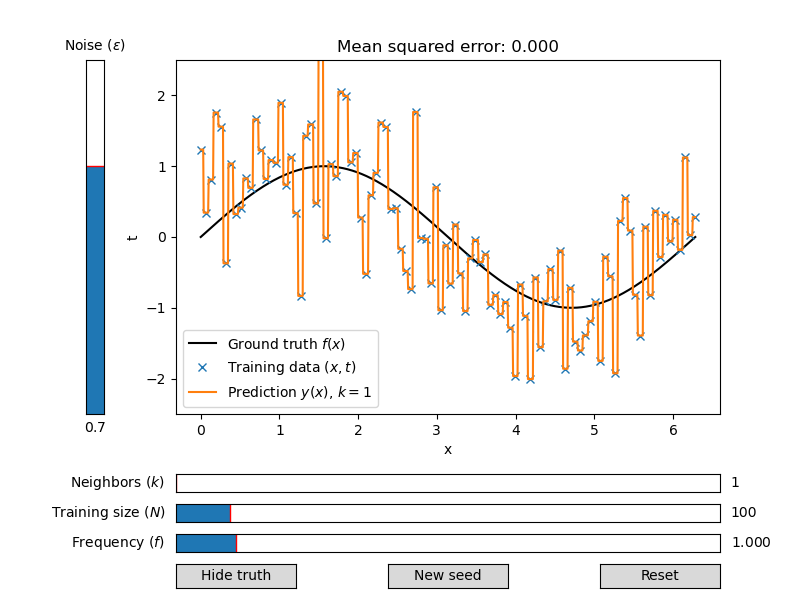

In [4]:
# Get the observed data
x, t = f_data(N=100)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Create the interactive plot including training error
plot1 = magicplotter(f_data, f, KNN, x_pred)
plot1.add_sliders('epsilon', 'k', 'N', 'f')
plot1.add_buttons('truth', 'seed', 'reset')
plot1.title = 'Mean squared error: {mse_train:.3f}'
plot1.show()

## Model selection
For k = 1 our error term is 0, yet the resulting model will not yield good predictions for unseen data. Our model has fitted the noise in the dataset, and therefore cannot generalize. Clearly, evaluating the squared loss on our training points does not suffice.

To solve this problem a validation set is introduced. This set consists of different observations from the same ground truth which are not included during training.

|   |   |
| :--- | :--- |
| **Training Loss:** | The value of the loss function based on all observations used to train a model |
| **Validation Loss:** | The value of the loss function based on observations not used during training, used for finding hyperparameters such as $k$ |
| **Test Loss:** | The value of the loss function based on observations not used during either training or validation, used for evaluating the fit of the final model (for example to compare to alternative models) |

We repeat the experiment above with an additional validation set for which we compute the validation loss. This validation error represents the error we obtain when making new predictions and is therefore a much better indication for assessing our model compared to the training error. Minimizing the error on this validation set allows us to find a good value for k.
<!-- Depending on the problem, it might not always be possible to simply create more data. Therefore we split the data we have into 2 seperate sets; one for training and one for validation. (Making sure to randomly shuffle the data before splitting) -->

<IPython.core.display.Javascript object>


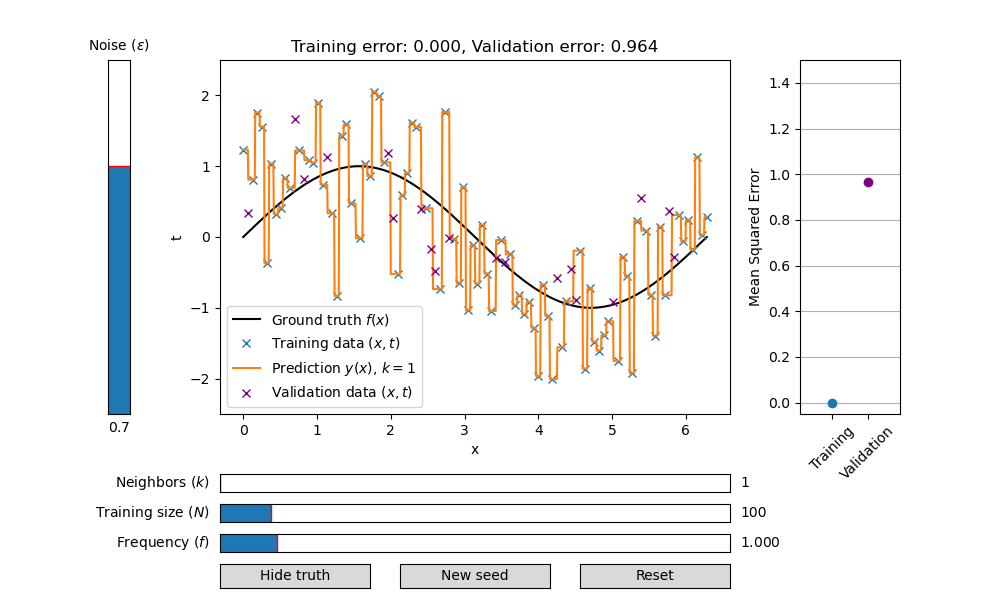

In [5]:
# Get the observed data
x, t = f_data(N=100)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Create the interactive plot including training error
plot2 = magicplotter(f_data, f, KNN, x_pred)
plot2.add_sliders('epsilon', 'k', 'N', 'f')
plot2.add_buttons('truth', 'seed', 'reset')
plot2.add_sidebar()
plot2.title = 'Training error: {mse_train:.3f}, Validation error: {mse_validation:.3f}'
plot2.show()

* For a training size $(N)$ of 100 and a wave length $(l)$ of 6.28, what is the value of $k$ for which the validation error is minimized?

## Bias-variance tradeoff

As we determined earlier, for the squared loss function the optimal prediction (which we will denote as $h(\mathbf{x})$) is given by:
$$ h(\mathbf{x})= \mathbb{E}[t|\mathbf{x}] = \int t p(t|\mathbf{x})dt $$
The loss can then be written as:
$$ \mathbb{E}[L] = \int \left( y(\mathbf{x}) - h(\mathbf{x}) \right) ^2 p(\mathbf{x}) d\mathbf{x} + \varepsilon $$

If we had an unlimited supply of data we could in principle find an optimal model $y(\mathbf{x})$ equivalent to $h(\mathbf{x})$. For any particular dataset $\mathcal{D}$ with a finite number of datapoints we cannot find this and instead our equation takes the form
$$ \left( y(\mathbf{x}; \mathcal{D}) - h(\mathbf{x}) \right) ^2 $$
Since this is dependent on the particular dataset $\mathcal{D}$, we take its average over an ensemble of datasets. We first add and subtract the quantity $\mathbb{E}_{\mathcal{D}} \left[ y(x; \mathcal{D}) \right]$ and then expand the terms:
$$ \left( y(\mathbf{x}; \mathcal{D}) - \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] + \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] - h(\mathbf{x}) \right) ^2 $$
$$ = \left( y(\mathbf{x}; \mathcal{D}) - \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] \right)^2 +
    \left( \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] - h(\mathbf{x}) \right) ^2
    +2 \left( y(\mathbf{x}; \mathcal{D}) - \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] \right)
    \left( \mathbb{E}_{\mathcal{D}} \left[ y(\mathbf{x}; \mathcal{D}) \right] - h(\mathbf{x}) \right) $$

Taking the expectation of this expression with respect to $\mathcal{D}$ will vanish the final term resulting in:

<!-- $$L(x) = \mathbb{E}_\mathcal{D} \left[ (y(x, \mathcal{D}) - \mathbb{E}_t[t|x])^2 \right] $$
where the irreducible noise has dissapeared due to averaging over the datasets. $\mathcal{D}$ is a specific dataset, and we are averaging over __all possible datasets.__
We can further split this:
-->

$$L(\mathbf{x}) = \left( \mathbb{E}_\mathcal{D} \left[ y(\mathbf{x}, \mathcal{D}) \right] - h(\mathbf{x}) \right)^2 + \mathbb{E}_\mathcal{D} \left[ (y(\mathbf{x}, \mathcal{D}) - \mathbb{E}_\mathcal{D} \left[ y(\mathbf{x}, \mathcal{D}) \right] )^2 \right] $$

$$ Loss \; = \; bias^2 \; + \; variance $$
where the irreducible noise has dissapeared due to averaging over the datasets. The resulting terms are considered the bias and the variance, and can be understood as follows:

**Bias**: the bias error represents the models inability to capture the overall behaviour of the data. (underfitting)
**Variance**: the variance error represents the extent to which the model is oversensitive to small fluctuations in the data such as noise. (overfitting)

For a more complete discussion we refer to Chapter 3.2 of "Bishop - Pattern Recognition And Machine Learning"

Looking back at the plot above try to answer the following questions:
* When k is low, do we have a high or low bias? And what about the variance?
* When k is high, do we have a high or low bias? And what about the variance?

We will now quantify the bias and variance by creating a large number of datasets and averaging over them, following the equation above. Notice that this is only possible because we know the true model in this example.


In [6]:
# TODO:
# - Check if the bias-variance formulas are correct. Should x be used again as validation set?
# - Find a way to move (parts of) the code below into magicplotter or some other function in mude_tools

num_models = 100
plot_length = 1000
# Reset default values
N = 50
k = 1
l = 2*np.pi
x = np.linspace(0, l, N)
noise = 0.7
seed = 0
# truth.set_data(x_pred, f(x_pred,l))

def make_preds(x=x, x_pred=x_pred, num_models=num_models, N=N, k=k, l=l, noise=noise):

    x = np.linspace(0, 2*np.pi, N)
    global seed
    # Array to store mean prediction in
    y_plot_mean_pred = np.zeros(len(x_pred))
    y_eval_mean_pred = np.zeros(len(x))
    # Store each model output; required for computing the variance
    model_ys = []

    # Loop over all models, iteratively update the mean
    for i in range(num_models):
        # Create a new dataset
        seed += 1
        t = f(x, l) + np.random.normal(0, noise, N)

        # Add the prediction to the mean
        y_plot, y_eval = KNN(x, t, x_pred, k, x)
        
        y_plot_mean_pred += y_plot / num_models
        y_eval_mean_pred += y_eval / num_models
        # Store model prediction
        model_ys.append(y_eval)

    # Compute the bias
    bias = np.sqrt(sum((y_eval_mean_pred - f(x, l))**2)/N)

    # Compute the variance
    # variances = np.zeros(len(x_pred))
    variance = np.zeros(N)
    for y in model_ys:
        variance += ((y-y_eval_mean_pred)**2)
    variance /= num_models

    return y_plot_mean_pred, bias, variance

# Run initial simulation:
y_plot_mean_pred, bias_val, variance_vals = make_preds(x, x_pred, num_models, N, k, l, noise)

# Computing intervals for plotting bias & variance
bias_bottom = y_plot_mean_pred-[bias_val]
bias_top = y_plot_mean_pred+[bias_val]
variance_plot_vals = np.repeat(variance_vals, int(plot_length/N))
variance_lower1 = y_plot_mean_pred-[bias_val]-variance_plot_vals
variance_lower2 = y_plot_mean_pred-[bias_val]
variance_upper1 = y_plot_mean_pred+[bias_val]
variance_upper2 = y_plot_mean_pred+[bias_val]+variance_plot_vals

fig, ax = plt.subplots(figsize=(8,7))

bias = ax.fill_between(x_pred, bias_bottom, bias_top, alpha=0.6, color='red', label='Average bias')
variance_1 = ax.fill_between(x_pred, variance_lower1, variance_lower2, color='red', alpha=0.3, label='Variance')
variance_2 = ax.fill_between(x_pred, variance_upper1, variance_upper2, color='red', alpha=0.3)
truth, = ax.plot(x_pred, f(x_pred, l), 'k-', label=r'Ground truth $f(x)$')
pred, = ax.plot(x_pred, y_plot_mean_pred, '-', label=r'$\mathbb{E}_{\mathcal{D}}[y(x)](k=$' + f'{k}$)$' )
ax.set_xlabel('x')
ax.set_ylim((-2.5, 2.5))
ax.legend()

# Adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.38)

###########
# Sliders #
###########

# Make a horizontal slider to control the number of neighbors
ax_k = plt.axes([0.25, 0.25, 0.65, 0.03])
k_slider = Slider(
    ax=ax_k,
    label=r'Neighbors ($k$)',
    valmin=1,
    valmax=100,
    valinit=1,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the number of datasets
ax_D = plt.axes([0.25, 0.20, 0.65, 0.03])
D_slider = Slider(
    ax=ax_D,
    label=r'# of datasets ($D$)',
    valmin=1,
    valmax=300,
    valinit=25,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the number of measurements
ax_N = plt.axes([0.25, 0.15, 0.65, 0.03])
N_slider = Slider(
    ax=ax_N,
    label=r'Training size ($N$)',
    valmin=2,
    valmax=200,
    valinit=N,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the wave length
ax_l = plt.axes([0.25, 0.1, 0.65, 0.03])
l_slider = Slider(
    ax=ax_l,
    label=r'Wave length ($l$)',
    valmin=0.5,
    valmax=8*np.pi,
    valinit=2*np.pi,
)

# Make a vertical slider to control the noise level
ax_eps = plt.axes([0.10, 0.38, 0.0225, 0.50])
eps_slider = Slider(
    ax=ax_eps,
    label=r'Noise ($\varepsilon$)',
    valmin=0,
    valmax=1,
    valinit=noise,
    orientation="vertical"
)

# Define an update function when a slider value changes
def update(event):

    global seed

    # Get the slider values
    k = int(min(k_slider.val, N_slider.val))
    D = int(D_slider.val)
    N = int(N_slider.val)
    l = l_slider.val
    noise = eps_slider.val

    # Run the models
    y_plot_mean_pred, bias_val, variance_vals = make_preds(x, x_pred, D, N, k, l, noise)

    # Update plots
    # Computing intervals for plotting bias & variance
    bias_bottom = y_plot_mean_pred-[bias_val]
    bias_top = y_plot_mean_pred+[bias_val]
    variance_plot_vals = np.repeat(variance_vals, int(plot_length/N))
    variance_lower1 = y_plot_mean_pred-[bias_val]-variance_plot_vals
    variance_lower2 = y_plot_mean_pred-[bias_val]
    variance_upper1 = y_plot_mean_pred+[bias_val]
    variance_upper2 = y_plot_mean_pred+[bias_val]+variance_plot_vals

    # Fills cannot be updated but are re-plotted
    global bias
    global variance_1
    global variance_2
    bias.remove()
    variance_1.remove()
    variance_2.remove()
    bias = ax.fill_between(x_pred, bias_bottom, bias_top, color='red', alpha=0.6, label='Average bias')
    variance_1 = ax.fill_between(x_pred, variance_lower1, variance_lower2, color='red', alpha=0.3, label='variance')
    variance_2 = ax.fill_between(x_pred, variance_upper1, variance_upper2, color='red', alpha=0.3)

    truth.set_data(x_pred, f(x_pred,l))
    pred.set_ydata(y_plot_mean_pred)

    # Update the legend
    pred.set_label(r'$\mathbb{E}_{\mathcal{D}}[y(x)](k=$' + f'{k}$)$')
    ax.legend()

    fig.canvas.draw_idle()

# Define a function that hides the ground truth
def toggle_truth(event):

    if truth.get_alpha() is None:
        truth.set_alpha(0)
        truth_button.label.set_text('Show truth')
    else:
        truth.set_alpha(None)
        truth_button.label.set_text('Hide truth')

    # update(event)

# Define a function that performs a reset
def reset_all(event):
    global seed

    seed = 0

    k_slider.reset()
    D_slider.reset()
    N_slider.reset()
    l_slider.reset()
    eps_slider.reset()

    if not truth.get_alpha() is None:
        toggle_truth(event)

    update(event)

# Connect the update function to each slider
k_slider.on_changed(update)
D_slider.on_changed(update)
N_slider.on_changed(update)
l_slider.on_changed(update)
eps_slider.on_changed(update)

###########
# Buttons #
###########

# Make a button to hide/show the truth
ax_truth = plt.axes([0.50, 0.025, 0.15, 0.04])
truth_button = Button(ax_truth, 'Hide truth', hovercolor='0.975')

# Make a button to go back to the initial settings
ax_reset = plt.axes([0.25, 0.025, 0.15, 0.04])
reset_button = Button(ax_reset, 'Reset', hovercolor='0.975')

truth_button.on_clicked(toggle_truth)
reset_button.on_clicked(reset_all)

plt.show()

TypeError: KNN() takes from 3 to 4 positional arguments but 5 were given

## Playing around with the plot
Understanding bias and variance is key for any method you use, and this will come back in many of the following lectures. Being able to answer some of the following questions can help you understand what is going on:
* Why is the variance small for a large $k$?
* Why is the bias not zero for $k=1$?
* Why does the bias increase when choosing a small wave length $l$?
* Why is the variance 0 when using a single dataset $D$?



## Final remarks

So far we have looked at our k-nearest neighbours regressor, which is relatively easy to understand and play around with. However in practice this method is not often used, as it scales poorly for large datasets. Furthermore, when considering multiple inputs (high-dimensions) computing the closest points becomes computationally expensive. In a limited data setting, taking the average of the closest neighbours will often lead to poor performance. k-nearest neighbours is also sensitive to outliers. In the next lecture, we will apply what we have learned to a different model, namely linear regression.